# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import glorot_uniform, ones, zeros
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten
from keras.regularizers import l2
import keras.backend as K
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import theano
import theano.tensor as T
!pip install lifelines
from lifelines.utils import concordance_index
!pip install h5py
import h5py

     |████████████████████████████████| 348 kB 34.7 MB/s 
     |████████████████████████████████| 55 kB 4.7 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=71ad31076625332bb15ecb45457ead761463d66b3dea48f160049352f72ef691
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [2]:
import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TU Delft/BEP')

Mounted at /content/drive


# **Import data**

### AML dataset

In [20]:
url = 'https://github.com/ThiesCalje/BEP/blob/main/Data_10_processed.xlsx?raw=true'
data = pd.read_excel(url)
#data = pd.read_excel(r'Data/Data_10_processed.xlsx')
data

,Sample_ID,"Treatment_Approach_(AML, ALL, Hybrid)",Treatment_Protocol,Treatment_FLT3_Inhibitor,Transcriptional_Identity,Immunophenotype,FAB_Designation,Key_Oncogenic_Driver_Event,FLT3_ITD_Allelic_Ratio,FLT3_ITD_Soft_Clip_Reads,Figure_1B_tSNE.x_coordinate,Figure_1B_tSNE.y_coordinate,LSC6_Score,LSC6_Category,Vital_Status,Survival_Days,Follow_Up_Days,EFS_Days,First_Event,SCT_in_First_Remission
0,SJAML001408_D1,AML,AML02,NO,11q23 rearranged,AML,M5a,KMT2Ar,NaN,NaN,-5.403937,-76.387834,0.204430,low,0,4930,4930,4930.0,Censored,No
1,SJAML001427_D2,AML,AML02,NO,MK-V,AML,M4,NPM1,NaN,NaN,-21.901230,-56.360340,-1.127061,low,1,118,118,118.0,TRM,No
2,SJAML001428_D1,AML,AML02,NO,MK-V,AML,M4,NaN,NaN,NaN,-26.705930,-53.003653,-1.377134,low,0,4543,4543,4543.0,Censored,No
3,SJAML001430_D2,AML,AML02,NO,MK-V,AML,M4,NPM1,NaN,NaN,-26.821585,-61.888154,-0.050137,low,0,4840,4840,1106.0,Relapse,No
4,SJAML001444_D1,AML,AML02,NO,MK-V,AML,M4,KMT2Ar,NaN,NaN,-32.526113,-77.818769,1.732514,medium,1,536,536,348.0,Relapse,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,SJAML040664_D1,AML,AAML0531,NO,11q23 rearranged,AML,M5,KMT2Ar,NaN,NaN,11.953182,-75.006689,0.824983,low,1,194,194,102.0,Relapse,No
405,SJAML040665_D1,AML,AAML0531,NO,MK-V,AML,M1,NUP-r,NaN,NaN,-48.554554,-34.861272,1.634902,medium,0,1652,1652,1652.0,Censored,NaN
406,SJAML040666_D1,AML,AAML0531,NO,inv(16),AML,M4,CBFB-MYH11,NaN,NaN,-40.725131,29.453953,0.200524,low,0,1464,1464,277.0,Relapse,No
407,SJAML040667_D1,AML,AAML0531,NO,MPAL-B/M,AML,M5,KMT2Ar,NaN,NaN,28.851693,-31.701042,0.691838,low,1,607,607,252.0,Relapse,No


In [51]:
T_ = data['Survival_Days']
E = data['Vital_Status']

data_split = {'categorical':["Sample_ID",
                             "Treatment_Approach_(AML, ALL, Hybrid)",
                             "Treatment_Protocol",
                             "Treatment_FLT3_Inhibitor",
                             "Transcriptional_Identity",
                             "Immunophenotype",
                             "FAB_Designation",
                             "Key_Oncogenic_Driver_Event",
                             "LSC6_Category",
                             "First_Event",
                             "SCT_in_First_Remission"],
              'numerical':["FLT3_ITD_Allelic_Ratio",
                           "FLT3_ITD_Soft_Clip_Reads",
                           "Figure_1B_tSNE.x_coordinate",
                           "Figure_1B_tSNE.y_coordinate",
                           "LSC6_Score",
                           "Vital_Status",
                           "Survival_Days",
                           "Follow_Up_Days",
                           "EFS_Days"],
              'keep_c':[],
              'keep_n':[]
              }

keep_variables = ["Key_Oncogenic_Driver_Event","LSC6_Score"]

for variable in keep_variables:

  if variable in data_split['categorical']:
    data_split['keep_c'].append(variable)
    data_split['categorical'].pop(data_split['categorical'].index(variable))

  else:
    data_split['keep_n'].append(variable)
    data_split['numerical'].pop(data_split['numerical'].index(variable))



data2 = pd.get_dummies(data, columns = data_split['keep_c'])
data2 = data2.drop(data_split['categorical']+data_split['numerical'],axis=1)


mx = max(abs(data2['LSC6_Score']))
data2['LSC6_Score'] = data2['LSC6_Score'] / mx

data2

,LSC6_Score,Key_Oncogenic_Driver_Event_BCL11B/FLT3 ITD,Key_Oncogenic_Driver_Event_CBFA2T3-GLIS2,Key_Oncogenic_Driver_Event_CBFB-MYH11,Key_Oncogenic_Driver_Event_CEBPA mono-allelic,"Key_Oncogenic_Driver_Event_CEBPA, bi-allelic",Key_Oncogenic_Driver_Event_ETS,Key_Oncogenic_Driver_Event_FLT3 ITD,Key_Oncogenic_Driver_Event_GATA1,Key_Oncogenic_Driver_Event_HOXr,Key_Oncogenic_Driver_Event_KAT6Ar,Key_Oncogenic_Driver_Event_KMT2A PTD,Key_Oncogenic_Driver_Event_KMT2Ar,Key_Oncogenic_Driver_Event_MNX1-r,Key_Oncogenic_Driver_Event_NPM1,Key_Oncogenic_Driver_Event_NUP-r,Key_Oncogenic_Driver_Event_PRC2,Key_Oncogenic_Driver_Event_Ph/Ph Like,Key_Oncogenic_Driver_Event_RUNX1r,Key_Oncogenic_Driver_Event_T Txn,Key_Oncogenic_Driver_Event_WT1 FLT3 ITD,Key_Oncogenic_Driver_Event_ZNF384
0,0.088251,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,-0.486545,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.594499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.021644,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.747914,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,0.356139,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
405,0.705776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
406,0.086565,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
407,0.298662,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [79]:
def data_filter(data,keep_variables, one_hot = False):
    T = data['Survival_Days']
    E = data['Vital_Status']

    data_split = {'categorical':["Sample_ID",
                             "Treatment_Approach_(AML, ALL, Hybrid)",
                             "Treatment_Protocol",
                             "Treatment_FLT3_Inhibitor",
                             "Transcriptional_Identity",
                             "Immunophenotype",
                             "FAB_Designation",
                             "Key_Oncogenic_Driver_Event",
                             "LSC6_Category",
                             "First_Event",
                             "SCT_in_First_Remission"],
                 'numerical':["FLT3_ITD_Allelic_Ratio",
                           "FLT3_ITD_Soft_Clip_Reads",
                           "Figure_1B_tSNE.x_coordinate",
                           "Figure_1B_tSNE.y_coordinate",
                           "LSC6_Score",
                           "Vital_Status",
                           "Survival_Days",
                           "Follow_Up_Days",
                           "EFS_Days"],
                'keep_c':[],
                'keep_n':[]
              }

    for variable in keep_variables:

        if variable in data_split['categorical']:
            data_split['keep_c'].append(variable)
            data_split['categorical'].pop(data_split['categorical'].index(variable))

        else:
            data_split['keep_n'].append(variable)
            data_split['numerical'].pop(data_split['numerical'].index(variable))

    data_c = data[data_split['keep_c']]
    data_n = data[data_split['keep_n']]
    if one_hot == True:
        data_c = pd.get_dummies(data_c,dummy_na=True)

    data = data_c.join(data_n)
    return data_c, data_n, data, E, T

In [87]:
keep_variables = ["LSC6_Score","Key_Oncogenic_Driver_Event"]
data_c, data_n, data1, E, T = data_filter(data,keep_variables,one_hot=True)
print(data_c, data_n, data1)
data1

     Key_Oncogenic_Driver_Event_BCL11B/FLT3 ITD  ...  Key_Oncogenic_Driver_Event_nan
0                                             0  ...                               0
1                                             0  ...                               0
2                                             0  ...                               1
3                                             0  ...                               0
4                                             0  ...                               0
..                                          ...  ...                             ...
404                                           0  ...                               0
405                                           0  ...                               0
406                                           0  ...                               0
407                                           0  ...                               0
408                                           0  ...             

,Key_Oncogenic_Driver_Event_BCL11B/FLT3 ITD,Key_Oncogenic_Driver_Event_CBFA2T3-GLIS2,Key_Oncogenic_Driver_Event_CBFB-MYH11,Key_Oncogenic_Driver_Event_CEBPA mono-allelic,"Key_Oncogenic_Driver_Event_CEBPA, bi-allelic",Key_Oncogenic_Driver_Event_ETS,Key_Oncogenic_Driver_Event_FLT3 ITD,Key_Oncogenic_Driver_Event_GATA1,Key_Oncogenic_Driver_Event_HOXr,Key_Oncogenic_Driver_Event_KAT6Ar,Key_Oncogenic_Driver_Event_KMT2A PTD,Key_Oncogenic_Driver_Event_KMT2Ar,Key_Oncogenic_Driver_Event_MNX1-r,Key_Oncogenic_Driver_Event_NPM1,Key_Oncogenic_Driver_Event_NUP-r,Key_Oncogenic_Driver_Event_PRC2,Key_Oncogenic_Driver_Event_Ph/Ph Like,Key_Oncogenic_Driver_Event_RUNX1r,Key_Oncogenic_Driver_Event_T Txn,Key_Oncogenic_Driver_Event_WT1 FLT3 ITD,Key_Oncogenic_Driver_Event_ZNF384,Key_Oncogenic_Driver_Event_nan,LSC6_Score
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.204430
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1.127061
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.377134
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.050137
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.732514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.824983
405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.634902
406,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.200524
407,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.691838


## Gaussian survival data

In [4]:
h5_file = 'Data/gaussian_survival_data_1.h5'

In [5]:
def normalize(X):
  X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
  return X

In [56]:
with h5py.File(h5_file, 'r') as f:
  X = f["train"]['x'][()]
  e = f["train"]['e'][()].reshape(-1, 1)
  y = f["train"]['t'][()].reshape(-1, 1)

x_train_gauss = pd.DataFrame(normalize(X))
y_train_gauss = pd.DataFrame(normalize(y))
E_train_gauss = pd.DataFrame(normalize(e))
y_train_gauss

,0
0,0.588690
1,0.330687
2,0.245398
3,1.000000
4,0.929369
...,...
3995,0.420099
3996,1.000000
3997,1.000000
3998,1.000000


# **Auto-encoding**

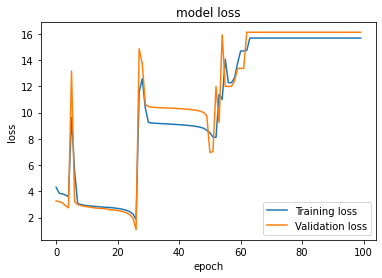

prediction =  
 [ 0.35109055  0.4520199  -1.2747805   0.97499484  0.5178706   0.6123378
  0.5452272   0.44757453  0.6423924   0.2398216  -0.25687563 -1.9863694
  0.5422417  -1.8460563  -1.3714124   0.8076776   0.2902527   0.7588859
 -0.49853373  1.          0.6670503  -1.0238893 ]
difference =  
 [[1.3947494  0.69236195 0.05027348 0.37655604 2.5500004  1.0081551 ]
 [0.8998946  2.8427198  0.6705364  0.5986937  0.74281263 1.1487119 ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.        

In [ ]:
def Autoencoder_em(data,em_dim,include_na):

  labels = pd.get_dummies(data,dummy_na=include_na)
  m = len(set(data))
  encoder = Sequential()

  encoder.add(Embedding(input_dim= m, output_dim= em_dim, input_length= m, embeddings_initializer=ones()))
  dif = abs(encoder.get_weights()[0])
  encoder.add(Flatten())
  encoder.add(Dense(m,kernel_initializer=glorot_uniform()))

  encoder.compile(loss= "categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.1))

  
  #encoder.summary()

  history = encoder.fit(labels, labels, epochs=100, shuffle=False, verbose=False,validation_split=0.2)
  dif = abs(dif - abs(encoder.get_weights()[0]))
  plot_history(history,0.2)
  pred = encoder.predict(labels)
  embeddings = encoder.get_weights()[0]

  return pred[0]/max(pred[0]), dif

pred, dif = Autoencoder_em(data_c["Key_Oncogenic_Driver_Event"],6, True)
print('prediction = ', '\n', pred)
print('difference = ', '\n', dif)

In [ ]:
def Autoencoder_(data,em_dim,include_na):

  labels = pd.get_dummies(data,dummy_na=include_na)
  m = len(set(data))
  encoder = Sequential()

  encoder.add(Embedding(input_dim= m, output_dim= em_dim, input_length= m, embeddings_initializer=ones()))
  encoder.add(Flatten())
  encoder.add(Dense(m,kernel_initializer=glorot_uniform()))

  encoder.compile(loss= "categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.1))

  
  #encoder.summary()

  history = encoder.fit(labels, labels, epochs=300, shuffle=False, verbose=False,validation_split=0.2)
  plot_history(history,0.2)
  pred = encoder.predict(labels)
  embeddings = encoder.get_weights()[0]

  return embeddings, pred[0]/max(abs(pred[0]))

print(Autoencoder(data_c["Key_Oncogenic_Driver_Event"],5, True))

# **Model**

In [68]:
def plot_history(history, validation_split=0):

  plt.plot(history.history['loss'],label='Training loss')

  if validation_split != 0:
    plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  #plt.legend()
  
  return 'plot'

In [52]:
def build_and_compile_model(E, T, hid_lay, dropout_rate, input,activation, L2, learning_rate, momemtum, embedding=False):

  model = Sequential()

  if embedding == True:
    print("do something")


  model.add(Dense(hid_lay[0], input_shape=(input,),
                kernel_initializer=glorot_uniform(),
                kernel_regularizer=l2(L2))) # shape= length, dimension
  model.add(Activation(activation))
  model.add(Dropout(dropout_rate))

  if len(hid_lay) != 1:
    for n in hid_lay[1:]:
        model.add(Dense(n,kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(L2))) # shape= length, dimension
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))


  model.add(Dense(1, activation="linear",
                    kernel_initializer=glorot_uniform(),
                    kernel_regularizer=l2(L2),
                    activity_regularizer=l2(0.01)))

  model.compile(loss=neg_log_likelihood(E,T),
                optimizer=tf.keras.optimizers.SGD(learning_rate, 
                                                  momentum)
  )
  return model

In [64]:
def neg_log_likelihood(E,T):
    def loss(y_true, y_pred):
        mask = np.ones((len(T), len(T)))
        mask[(y.T - y) > 0] = 0
        print(mask)
        hazard_ratio = K.exp(y_pred)*mask
        log_risk = K.log(K.cumsum(hazard_ratio, axis=1)) / np.sum(mask,axis=0)
        uncensored_likelihood = y_pred - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood = -K.sum(censored_likelihood)/sum(E)
        return neg_likelihood
    return loss

# **Experiments**

In [74]:
def model_experiment(data, E, T, hidden_layers, dropout_rate, activation, L2, learning_rate, momemtumn ,labels = None, plot = False):
  c = []
  #print(len(labels), data.shape,len(E))
  fig1 = plt.figure(figsize=(10,10))
  for i in range(n):
    input = data.shape[1]
    model = build_and_compile_model(E,
                                    T,
                                    hidden_layers, 
                                    dropout_rate, 
                                    input, 
                                    activation, 
                                    L2, 
                                    learning_rate, 
                                    momentum)
    model.build()
    #model.summary()

    history = model.fit(data, 
                        labels, 
                        epochs=1000, 
                        shuffle=False, 
                        verbose=False,
                        validation_split=0)  # Shuffle False --> Important!!
    if plot == True:
      plot_history(history)
    h_est = model.predict(data)
    #print(h_est[:2])
    c.append(concordance_index(T,-h_est , E))

  fig2 = plt.figure()
  plt.hist(c,bins=10)
  return np.mean(c)


In [ ]:
n = 1
hidden_layers = [17,17,17]
dropout_rate = 0.401
activation = 'relu'
L2 = 4.425
learning_rate = 3.173*pow(10,-4)
momentum = 0.936
t = model_experiment(x_train_gauss, 
                     E_train_gauss, 
                     y_train_gauss, 
                     hidden_layers, 
                     dropout_rate, 
                     activation, 
                     L2, 
                     learning_rate, 
                     momentum, 
                     labels = y_train_gauss)
print("the average concordance-index = ", t)

0.4972489738712584


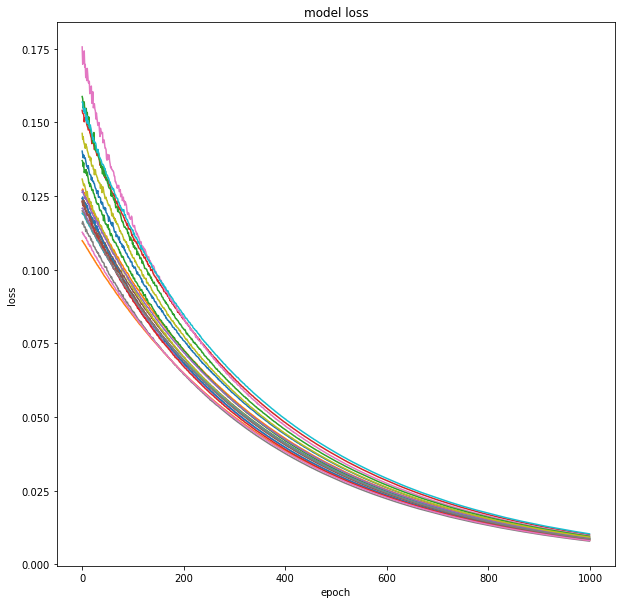

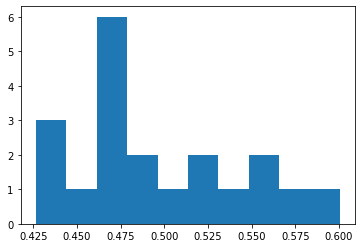

In [76]:
hidden_layers = [4,4]
dropout_rate = 0.4
activation = 'selu'
n = 20
L2 = 0.01
learning_rate = 3.173*pow(10,-4)
momentum = 0.936
t = model_experiment(data2, 
                     E, 
                     T_true, 
                     hidden_layers, 
                     dropout_rate, 
                     activation, 
                     L2, 
                     learning_rate, 
                     momentum,
                     plot = True)
print(t)

None


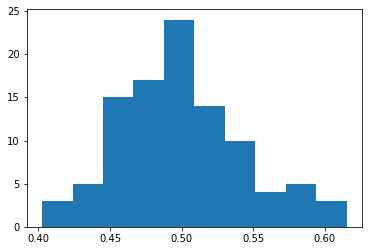

In [ ]:
hidden_layers = [4,4]
dropout_rate = 0
activation = 'selu'
t = model_experiment(hidden_layers,dropout_rate,activation,n=100)
print(t)

None


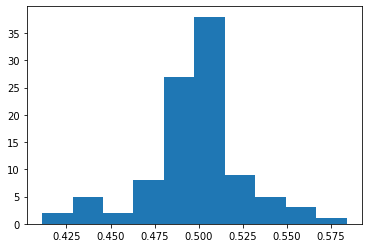

In [ ]:
hidden_layers = [4,10,2]
dropout_rate = 0
activation = 'relu'
t = model_experiment(hidden_layers,dropout_rate,activation,n=100)
print(t)

None


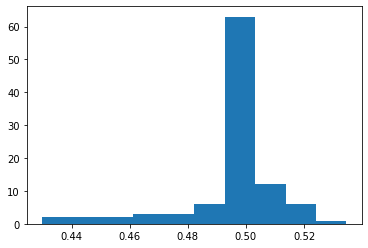

In [ ]:
hidden_layers = [4,10,2]
dropout_rate = 0.15
activation = 'relu'
t = model_experiment(hidden_layers,dropout_rate,activation,n=100)
print(t)